<a href="https://colab.research.google.com/github/CoderAPS/anomaly_detection/blob/main/anomaly(outlier)_detection_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Using Autoencoders in Tensorflow Keras for Anomaly Detection ###

Ref: https://pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/<br>

Ref: https://alpersinbalc.medium.com/using-autoencoders-in-tensorflow-keras-for-anomaly-detection-2ce9c34435ce<br>

Discovering Anomalous Data with Self-Supervised Learning:<br>
https://blog.research.google/2021/09/discovering-anomalous-data-with-self.html

Intro to Autoencoders<br>
https://www.tensorflow.org/tutorials/generative/autoencoder

Check it out<br>
https://arxiv.org/abs/2206.03687

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

# import the necessary packages
#from pyimagesearch.convautoencoder import ConvAutoencoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import cv2
import os

%matplotlib inline

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64, 128), latentDim=16):
    # build encoder
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs

		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
			#x = Dropout(0.1)(x)

		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		print(f'volumeSize: {volumeSize}')
		x = Flatten()(x)
		latent = Dense(latentDim)(x)

		# build the encoder model
		encoder = Model(inputs, latent, name="encoder")

    # start building the decoder model which will accept the
		# output of the encoder as its inputs
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)
		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")
		# our autoencoder is the encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)),
			name="autoencoder")
		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, autoencoder)

In [ ]:
def build_unsupervised_dataset(data, labels, validLabels, dataset_type,seed=42,
                               add_anomalyLabel=False, anomalyLabel=[3],
															contam = 0.01):

	# grab all indexes of the supplied class label that are *truly*
	# that particular label, then grab the indexes of the image
	# labels that will serve as our "anomalies"
	valid_idxs = []
	for v in validLabels:
		v_idxs = list(np.where(labels == v)[0])
		valid_idxs += v_idxs

	anomaly_idxs = []
	if add_anomalyLabel:
		for a in anomalyLabel:
			a_idxs = list(np.where(labels == a)[0])
			anomaly_idxs += a_idxs

		# compute the total number of anomaly data points to select
		i = int(len(valid_idxs) * contam)
		anomaly_idxs = anomaly_idxs[:i]
		random.shuffle(anomaly_idxs)
	print(f'Dataset {dataset_type} has: {len(valid_idxs)} valid images\
	& {len(anomaly_idxs)} anomaly images')


	# randomly shuffle both sets of indexes
	random.shuffle(valid_idxs)

	outliers = None
	# use NumPy array indexing to extract both the valid images and
	# "anomlay" images
	if add_anomalyLabel:
		valid_images = data[valid_idxs]
		anomaly_images = data[anomaly_idxs]
		outliers = data[anomaly_idxs]
		images = np.vstack([valid_images,anomaly_images])
	else:
		images = data[valid_idxs]

	# return the set of images
	return [images,outliers]

In [ ]:
def visualize_predictions(decoded, gt, idxs):

	# initialize our list of output images
	outputs = None

	# loop over our number of output samples
	for i in idxs:
		# grab the original image and reconstructed image
		original = (gt[i] * 255).astype("uint8")
		recon = (decoded[i] * 255).astype("uint8")
		# stack the original and reconstructed image side-by-side
		output = np.hstack([original, recon])
		# if the outputs array is empty, initialize it as the current
		# side-by-side image display
		if outputs is None:
			outputs = output
		# otherwise, vertically stack the outputs
		else:
			outputs = np.vstack([outputs, output])

	# return the output images
	return outputs

In [ ]:
# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, trainY), (testX, testY)) = mnist.load_data()

# Resize image to 32 X 32
trainX_rsz = np.zeros(shape=(len(trainX),32,32))
testX_rsz = np.zeros(shape=(len(testX),32,32))

for idx,arr in enumerate(trainX):
  trainX_rsz[idx] = cv2.resize(trainX[idx],(32,32),interpolation=cv2.INTER_NEAREST)

for idx,arr in enumerate(testX):
  testX_rsz[idx] = cv2.resize(testX[idx],(32,32),interpolation=cv2.INTER_NEAREST)

print(f'trainX_rsz shape: {trainX_rsz.shape} & testX_rsz shape: {testX_rsz.shape}')
print(f'trainY shape: {trainY.shape} & testY shape: {testY.shape}')

# build unsupervised train dataset of images consisting of 0,1,2 (valid_images)
print("[INFO] creating unsupervised dataset...")
train_images = build_unsupervised_dataset(trainX_rsz, trainY, dataset_type='TRAIN',
                                          validLabels=[0,1,2])[0]

# build unsupervised test dataset of images with a small amount of
# contamination (i.e., anomalies) added into it (anomaly_images)
test_images = build_unsupervised_dataset(testX_rsz, testY, dataset_type='TEST',
                                         validLabels=[0,1,2],add_anomalyLabel=True)[0]

#outliers = build_unsupervised_dataset(testX, testY, dataset_type='TEST',
#                                         validLabels=[0,1,2],add_anomalyLabel=True)[1]


# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
train_images = np.expand_dims(train_images, axis=-1)
train_images = train_images.astype("float32") / 255.0

test_images = np.expand_dims(test_images, axis=-1)
test_images = test_images.astype("float32") / 255.0

print(f'train_images shape: {train_images.shape} & test_images shape: {test_images.shape}')

# construct the training and validation split for
(trainX, valX) = train_test_split(train_images, test_size=0.2,
	random_state=42)



[INFO] loading MNIST dataset...
trainX_rsz shape: (60000, 32, 32) & testX_rsz shape: (10000, 32, 32)
trainY shape: (60000,) & testY shape: (10000,)
[INFO] creating unsupervised dataset...
Dataset TRAIN has: 18623 valid images	& 0 anomaly images
Dataset TEST has: 3147 valid images	& 31 anomaly images
train_images shape: (18623, 32, 32, 1) & test_images shape: (3178, 32, 32, 1)


In [ ]:
len(outliers)

31

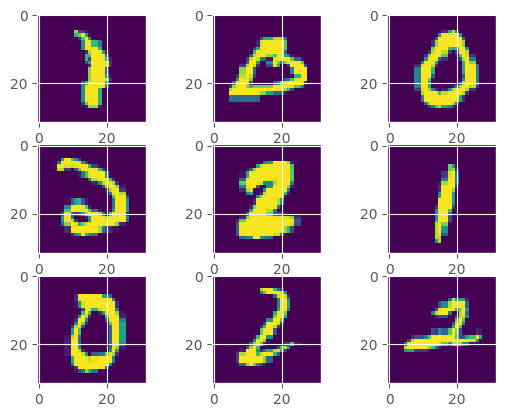

In [ ]:

random_picks = np.random.choice(range(len(test_images)),9)
for idx,num in enumerate(random_picks):
  plt.subplot(3,3,idx+1)
  plt.imshow(test_images[num])




In [ ]:
outliers

In [ ]:
def lrfn(lr):
  return lr

In [ ]:
# callbacks
def build_model_callbacks(store_at):
  callbacks = []
  checkpoint_path = store_at
  ## save best model
  sv = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_path,
      monitor='val_loss',
      verbose=1,
      save_best_only=True,
      save_weights_only=False,
      mode='min')

  callbacks +=[sv]

  early_stop = tf.keras.callbacks.EarlyStopping(
      monitor="val_loss",
      patience=10,
      start_from_epoch=0,
  )


  callbacks += [early_stop]

  lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

  callbacks += [lr_callback]

  #lr_callback = get_lr_callback()

  #callbacks += [lr_callback]

  return callbacks

In [ ]:
callbacks = build_model_callbacks('outliers')

In [ ]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 20
INIT_LR = 1e-3
BS = 32


In [ ]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(32, 32, 1)
opt = Adam(learning_rate=INIT_LR, weight_decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)
print(f'autoencoder: {autoencoder.summary()}')
print('-'*100)
print(f'encoder: {encoder.summary()}')
print('-'*100)
print(f'decoder: {decoder.summary()}')
print('-'*100)

# train the convolutional autoencoder
H = autoencoder.fit(
	trainX, trainX,
	validation_data=(valX, valX),
	epochs=EPOCHS,
	batch_size=BS)


[INFO] building autoencoder...
volumeSize: (None, 4, 4, 128)
Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                126352    
                                                                 
 decoder (Functional)        (None, 32, 32, 1)         275841    
                                                                 
Total params: 402193 (1.53 MB)
Trainable params: 401297 (1.53 MB)
Non-trainable params: 896 (3.50 KB)
_________________________________________________________________
autoencoder: None
----------------------------------------------------------------------------------------------------
Model: "encoder"
_________________________________________________________________
 Layer (type)       

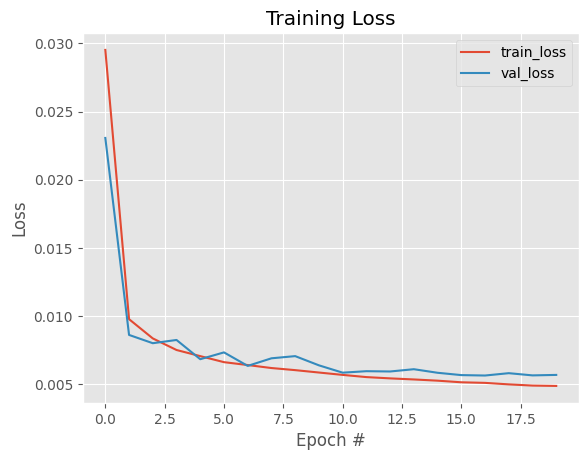

In [ ]:
# construct a plot that plots and saves the training history
N = np.arange(0, len(H.history['loss']))
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()
#plt.savefig(args["plot"])

# serialize the image data to disk
#print("[INFO] saving image data...")
#f = open(args["dataset"], "wb")
#f.write(pickle.dumps(images))
#f.close()

# serialize the autoencoder model to disk
#print("[INFO] saving autoencoder...")
#autoencoder.save(args["model"], save_format="h5")

In [ ]:
#H.history

In [ ]:
# use the convolutional autoencoder to make predictions on the
# testing images, construct the visualization, and then save it
# to disk
print("[INFO] making predictions...")
decoded = autoencoder.predict(test_images)
vis = visualize_predictions(decoded, test_images,[i for i in range(0,20)])
#cv2.imwrite(args["vis"], vis)

[INFO] making predictions...
100/100 [==============================] - 1s 5ms/step


In [ ]:
cv2.imwrite("OvD.png", vis)


True

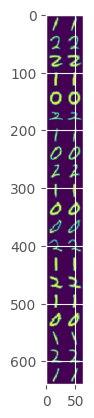

In [ ]:
ori_vs_deco = plt.imread('OvD.png')
plt.imshow(ori_vs_deco);

In [ ]:
errors = []
o_d_e = []

# loop over all original images and their corresponding
# reconstructions
for (image, recon) in zip(test_images, decoded):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	mse = np.mean((image - recon) ** 2)
	errors.append(mse)
	o_d_e.append([image,recon,mse])

In [ ]:
#sorted_errors = sorted(errors)
#sorted_errors[-40:]

In [ ]:
thresh = np.quantile(errors, 0.99)
idxs = np.where(np.array(errors) > thresh)[0]
print(f"idxs: {idxs}")
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))

idxs: [ 286  568  591  706  896  916 1080 1371 1552 1869 1871 1882 2134 2339
 2383 2490 2578 2603 2631 2656 2689 2891 2970 3085 3151 3156 3157 3159
 3160 3167 3169 3172]
[INFO] mse threshold: 0.023905396051704886
[INFO] 32 outliers found


In [ ]:
# loop over the indexes of images with a high mean squared error term
for i in idxs:
	# grab the original image and reconstructed image
	original = (test_images[i] * 255).astype("uint8")
	recon = (decoded[i] * 255).astype("uint8")
	#print(f'original shape: {test_images[i].shape} & recon shape: {decoded[i].shape}')
	# stack the original and reconstructed image side-by-side
	output = np.hstack([original, recon])

	outputs = None
	# if the outputs array is empty, initialize it as the current
	# side-by-side image display
	if outputs is None:
		outputs = output

	# otherwise, vertically stack the outputs
	else:
		outputs = np.vstack([outputs, output])


In [ ]:
outliers = visualize_predictions(decoded, test_images,idxs)
cv2.imwrite('anomality.png', outliers)

True

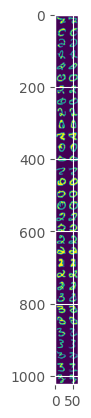

In [ ]:
OvD_a = plt.imread('anomality.png')
plt.imshow(OvD_a);

In [ ]:
from IPython.display import clear_output

In [ ]:
o_d_e = sorted(o_d_e, key= lambda x: x[2],reverse=True)

In [ ]:
for i in range(len(o_d_e)):
  print(f'MSE: {o_d_e[i][2]}')
  plt.imshow(o_d_e[i][0])
  plt.show()
  clear_output(wait=True)

MSE: 0.0096048042178154


KeyboardInterrupt: 